# Relative Economic Value (REV)

Relative Economic Value (REV) measures the economic benefit of using forecasts compared to a baseline strategy (climatology), relative to a perfect forecast. Unlike accuracy-based metrics, REV evaluates forecasts in terms of the decisions being made and the economic consequences of those decisions.

## Understanding Cost-Loss Decision Making

Consider a decision maker who must choose to take action to protect against a weather event or to do nothing, and that choice depends exclusively on the belief that the event will occur or not. For example, a user may choose to "grit the roads" (which costs C in labor and materials) or do nothing. If the event happens and there was no protection, then there is an economic loss L due to traffic delays, accidents and injuries on icy roads. When the event happens and protection is in place, the loss is reduced (L - L<sub>1</sub>). 

<table align="center">
  <tr>
    <td>Action \ Outcome</td>
    <td>Event Does Not Occur</td>
    <td>Event Occurs</td>
  </tr>
  <tr>
    <td>Do Not Protect</td>
    <td>0</td>
    <td>L</td>
  </tr>
  <tr>
    <td>Protect</td>
    <td>C</td>
    <td>C + L - L<sub>1</sub></td>
  </tr>
</table>

Similarly, the performance of yes/no type forecasts is often shown in a contingency table, sometimes called a confusion matrix. Here, the totals are normalised so the cells sum to 1. 

<table align="center">
  <tr>
    <td>Forecast \ Outcome</td>
    <td>Event Does Not Occur</td>
    <td>Event Occurs</td>
    <td></td>
  </tr>
  <tr>
    <td>Forecast to Not Occur</td>
    <td>Correct Negative</td>
    <td>Miss</td>
    <td>Correct Negative + Miss</td>
  </tr>
  <tr>
    <td>Forecast to Occur</td>
    <td>False Alarm</td>
    <td>Hit</td>
    <td>False Alarm + Hit</td>
  </tr>
  <tr>
    <td></td>
    <td>False Alarm + Correct Negative = 1 - ō</td>
    <td>Miss + Hit = ō</td>
    <td>sum(all) = 1</td>
  </tr>
</table>

$\overline{o}$ is the climatological frequency of the event occurring, as defined in the table. For example, icy roads happen 5% of days per year. 

From this table can be derived some common forecast performance metrics:  

$$
H = \text{Hit Rate} = \frac{\text{Hit}}{\text{Hit} + \text{Miss}} = \frac{\text{Hit}}{\bar{o}}
$$

$$
F = \text{False Alarm Rate} = \frac{\text{False Alarm}}{\text{False Alarm} + \text{Correct Negative}} = \frac{\text{False Alarm}}{1 - \bar{o}} 
$$

In the absense of forecasts, the decision maker may choose to always protect, which has an expense C + $\overline{o}$(L-L<sub>1</sub>). If the decision is to never protect, the expense is $\overline{o}$ L. The decision maker wants to follow a strategy that minimises expenses which is to always act when C + $\overline{o}$(L-L<sub>1</sub>) < $\overline{o}$ L (i.e. C < $\overline{o}$ L<sub>1</sub>) and never act otherwise. This leads to the expected expense 

$$
E_{\text{climate}} = \min \{ C + \overline{o}(L - L_1), \overline{o}L \}
$$

With perfect foreknowledge of the future weather, the decision maker only needs to protect when an event will occur, and not protect otherwise. This leads to the expected expense

$$
E_{\text{perfect}} = \overline{o}(C + L - L_1)
$$

Then we can define the Relative Economic Value of the forecast system 

$$
\text{REV} = \frac{E_{\text{clim}} - E_{\text{forecast}}}{E_{\text{clim}} - E_{\text{perfect}}}
$$

where 

- REV = 1: Perfect forecast value (as good as perfect information)
- REV = 0: No value over climatology
- REV < 0: Forecast is worse than using climatology
- REV between 0 and 1: Partial value between perfection and climatology

Combining this table with the previous information we get the expected expense of using the forecasts

$$
E_{\text{forecast}} = F (1 - \overline{o}) C - H \overline{o} (L_1 - C) + \overline{o} L
$$

Further we can define a "cost-loss" ratio

$$
\alpha = \frac{C}{L_1}
$$

And derive the full equation of the Relative Economic Value of the forecasts

$$
REV = \frac{\min(\alpha, \bar{o}) - F\alpha(1 - \bar{o}) + H\bar{o}(1 - \alpha) - \bar{o}}{\min(\alpha, \bar{o}) - \bar{o}\alpha}
$$

## Limitations of REV

The Cost-Loss Decision Model collapses the decision into "protect" and "don't protect" when in reality many decision-makers have a more graduated approach (e.g., drive safe social media messaging, grit the most vulnerable roads, grit all the roads, mandate a stay-at-home order). Similarly, the cost of each event can depend on its intensity, such that a severe frost might have different effects than a marginal one, but the contingency table treats all events as equally severe. Further, there can be compounding disasters, such as when freezing conditions coincide with a power failure (which might have nothing to do with the weather). 

The Model assumes that the in-sample frequency of the event is the same as the climatological chance. This might be true in a stable climate and over a large enough collection of forecasts. It is possible to have the decision-maker assume something different about the climatology, but that is not implemented here. 

The Model also assumes a completely rational decision maker, when in practice users exhibit loss aversion (misses are worse than false alarms), availability bias (recent events are more memorable), and there is organisational inertia. In some cases, such as water management on international rivers, fixed legal frameworks do not allow the use of forecasts, despite their seemingly obvious benefit. 

Most seriously, cost-loss information for real world examples is nearly non-existent. In many cases, the information is commercially or politically sensitive. It is also difficult to fully quantify impacts (e.g., When salt is applied to roads, what is the environmental impact of the runoff? What is the corrosion to vehicles and roads? What are the costs of maintaining gritting vehicles? What are the costs of monitoring the forecasts and developing gritting protocols?)


In [1]:
from scores.probability import relative_economic_value
from scores.processing import binary_discretise_proportion

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# To learn more about the implementation of REV, uncomment the following
# help(relative_economic_value)

## Basic Usage: Binary Forecasts

Let's start with a simple example using binary forecasts (0 or 1) to evaluate road gritting decisions. Thornes (2002) studied the value of road gritting along a particular section of motorway in the UK in the winter of 1995-96. He found the following costs of gritting for one night and the consequences of not gritting when there is frost. 

<table align="center">
  <tr>
    <td>Action \ Outcome</td>
    <td>No Frost</td>
    <td>Frost</td>
  </tr>
  <tr>
    <td>Do Nothing</td>
    <td>0</td>
    <td>£160,000</td>
  </tr>
  <tr>
    <td>Grit Roads</td>
    <td>£20,000</td>
    <td>£20,000</td>
  </tr>
</table>

It was assumed that gritting roads prevented all loss (L<sub>1</sub> = L, or equivalently L - L<sub>1</sub> = 0 )

Then the performance of the forecasts over 77 nights was

<table align="center">
  <tr>
    <td>Forecast \ Outcome</td>
    <td>No Frost Observed</td>
    <td>Frost Observed</td>
  </tr>
  <tr>
    <td>No Frost Forecast</td>
    <td>38</td>
    <td>4</td>
  </tr>
  <tr>
    <td>Frost Forecast</td>
    <td>6</td>
    <td>29</td>
  </tr>
  <tr>
    <td></td>
    <td>1 - ō = 57%</td>
    <td>ō = 43%</td>
  </tr>
</table>

In [3]:

cost = 20000  # Cost of gritting roads
loss = 160000  # Loss if roads are not gritted and frost occurs

alpha = cost / loss  # Cost-loss ratio

obar = (4 + 29)/ 77 # Observed climatological frequency of frost (over the winter days considered)

print(f"Cost-loss ratio (alpha) = {alpha:.3f}")
print(f"Climatological event frequency = {100*obar:.1f}%")

value_perfect = cost * obar * 77  
value_always_acting = cost * 77 
value_never_acting = loss * obar * 77 

print(f"Loss of never gritting = £{value_never_acting:,.0f}")
print(f"Cost of gritting the roads every night = £{value_always_acting:,.0f}")
print("In absence of a forecast, always gritting the roads is better than never gritting.")

print(f"Costs and losses with perfect foreknowledge = £{value_perfect:,.0f}")

cost_of_false_alarms = 6 * cost
cost_of_hits = 29 * cost 
cost_of_misses = 4 * loss
cost_of_non_events = 0

total_forecast_cost = cost_of_false_alarms + cost_of_hits + cost_of_misses + cost_of_non_events

print(f"Costs and losses when using actual forecasts = £{total_forecast_cost:,.0f}")

rev_calculated_manually = (value_always_acting - total_forecast_cost) / (value_always_acting - value_perfect)

print(f"Relative economic value of forecasts (calculated manually) = {100*rev_calculated_manually:.1f}%")


Cost-loss ratio (alpha) = 0.125
Climatological event frequency = 42.9%
Loss of never gritting = £5,280,000
Cost of gritting the roads every night = £1,540,000
In absence of a forecast, always gritting the roads is better than never gritting.
Costs and losses with perfect foreknowledge = £660,000
Costs and losses when using actual forecasts = £1,340,000
Relative economic value of forecasts (calculated manually) = 22.7%


Now let's calculate this using the scores REV code

In [4]:
fcst_binary = xr.DataArray(
    [1] * 29 + [0] *  4 + # frost observed 
    [1] *  6 + [0] * 38,  # no frost observed
    dims=["day"],
    coords={"day": np.arange(77)}
)

obs = xr.DataArray(
    [1] * 29 + [1] *  4 + # frost observed 
    [0] *  6 + [0] * 38,  # no frost observed
    dims=["day"],
    coords={"day": np.arange(77)}
)

rev_from_scores = relative_economic_value(fcst_binary, obs, cost_loss_ratios=alpha)

print("Relative economic value of forecasts (calculated using scores):")
print(rev_from_scores)


Relative economic value of forecasts (calculated using scores):
<xarray.DataArray (cost_loss_ratio: 1)> Size: 8B
array([0.22727273])
Coordinates:
  * cost_loss_ratio  (cost_loss_ratio) float64 8B 0.125


## Probabilistic Forecasts

Many forecasts are not simply yes/no but rather provide probabilities of what might happen. The REV score can also assess the value of these forecasts, by considering various thresholds for action. For example, if the forecast probability of frost is more than a certain percent, then the decision-maker will act as though frost is expected to occur.  

Let's take the above example and imagine the forecasts were a set of probabilities of varying magnitudes, in practice from 5% to 95% chance of frost.  


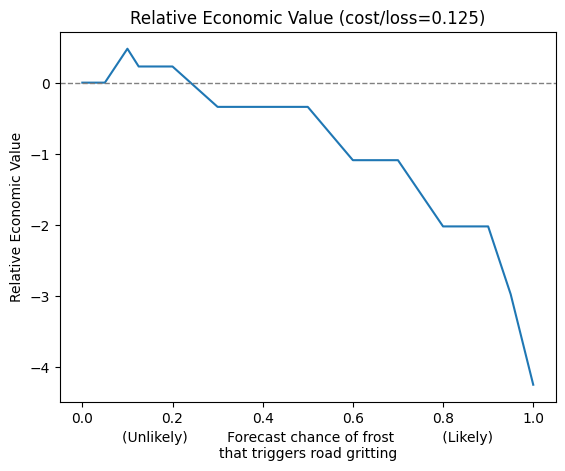

In [5]:
fcst_probabilistic = xr.DataArray(
    # high chance of frost                                          # low chance of frost 
    [0.95] * 8 + [0.9] * 6 + [0.75] * 6 + [0.5] * 5 + [0.25] * 4 + [0.1] *  3 + [0.05] *  1 + # frost happened
    [0.95] * 0 + [0.9] * 0 + [0.75] * 1 + [0.5] * 2 + [0.25] * 3 + [0.1] * 10 + [0.05] * 28,  # no frost happened
    dims=["day"],
    coords={"day": np.arange(77)}
)

obs = xr.DataArray(
    [1] * 29 + [1] *  4 + # frost happened
    [0] *  6 + [0] * 38,  # no frost happened
    dims=["day"],
    coords={"day": np.arange(77)}
)

thresholds = [0, 0.05, 0.1, 0.125, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]

rev_probability = relative_economic_value(fcst_probabilistic, obs, cost_loss_ratios=alpha, threshold=thresholds)

rev_probability.plot.line(x='threshold', add_legend=False)

plt.title(f"Relative Economic Value (cost/loss={alpha:.3f})")
plt.xlabel("(Unlikely)         Forecast chance of frost           (Likely)\nthat triggers road gritting")
plt.ylabel("Relative Economic Value")
plt.axhline(0, color='gray', linewidth=1, linestyle='--')
plt.show()


Remember that REV is the forecast value relative to perfect foreknowledge versus acting on climatological information. From earlier, for this particular cost/loss ratio, acting on climatological information would mean gritting every night.   

In the above graph, the far left hand side shows every forecast is triggering the user to grit the roads, which is the same as the fall-back (climatological) strategy without forecasts, so REV = 0. On the far right hand side of the graph, none of the forecasts trigger action and so: 

$$
\text{REV} = \frac{E_{\text{always grit}} - E_{\text{never grit}}}{E_{\text{always grit}} - E_{\text{perfect}}} = 
\frac{£1,540,000 - £5,280,000}{£1,540,000 - £660,000} = -4.25
$$

In this particular case, the highest REV happens at forecast threshold = 10%. Therefore, the optimal strategy for this user is to only grit the roads when the forecast is for >10% chance of frost. This may seem cautious but this is due to the low cost of protecting relative to the high cost of a missed event. 

## Visualizing the Economic Value Curve

So far, we have been considering one particular decision-maker but we can generalise the problem to consider a range of decision-makers. For example, commercial horticulture might deploy expensive heaters, airports may engage in de-icing, community services may check on vulnerable populations and so on. Each sector would have a different cost-loss ratio, particular to their decision-making context. 

First, start with a case in which the decision has been made (perhaps by the forecast producer) that any forecast of > 40% chance of frost will go out as a warning that frost will occur. Forecasts of < 40% chance will signal no frost. Then we calculate REV for a wide range of possible decision-makers. For simplicity, highly negative values are not shown. 

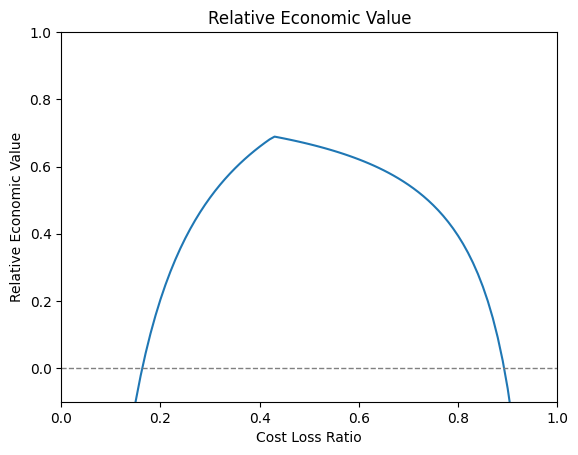

In [6]:
alphas = np.linspace(0, 1, 100, endpoint=False)

rev_many_users = relative_economic_value(fcst_probabilistic, 
                                         obs, 
                                         cost_loss_ratios=alphas,
                                         threshold=[0.4]
                                         )

rev_many_users.plot.line(x='cost_loss_ratio', hue='threshold', add_legend=False)

plt.title(f"Relative Economic Value")
plt.xlabel("Cost Loss Ratio")
plt.ylabel("Relative Economic Value")
plt.ylim(-0.1, 1) 
plt.axhline(0, color='gray', linewidth=1, linestyle='--')
plt.xlim(0, 1) 
plt.show()


For users with a cost-loss of around 0.4-0.6, the forecasts are highly valuable. However, when the cost-loss is very low (left side of the graph), just a few missed events can mean catastrophic losses. On the right side, the cost of protection is so high that any false alarms would mean too high levels of waste. 

## Working With Weights

When evaluating forecasts over large spatial domains, simple averaging can be misleading. Grid cells near the poles represent smaller areas than cells near the equator, yet naive averaging treats them equally. Cosine weighting corrects this by applying weights proportional to cos(latitude), matching the actual surface area each grid cell represents.

This example shows weighting by latitude, but it is possible to weight by any dimension of the input data, such as time for particularly interesting events. The weights array only needs the dimensions you are weighting (here, just `lat`). Xarray broadcasts it automatically across `time` and `lon` dimensions, so you do not need to manually expand the weights to match the full forecast shape.



In [7]:
fcst_lat30 = [1] * 5 + [0] * 5 + [1] * 10 + [0] * 80
obs_lat30 = [1] * 5 + [1] * 5 + [0] * 10 + [0] * 80

# Latitude 45°: Moderate skill (REV = 0.5)
fcst_lat45 = [1] * 7 + [0] * 3 + [1] * 8 + [0] * 82
obs_lat45 = [1] * 7 + [1] * 3 + [0] * 8 + [0] * 82

# Latitude 60°: Higher skill (REV = 0.75)
fcst_lat60 = [1] * 9 + [0] * 1 + [1] * 6 + [0] * 84
obs_lat60 = [1] * 9 + [1] * 1 + [0] * 6 + [0] * 84

# Stack into spatial arrays: (time, lat, lon)
fcst_data = np.array([fcst_lat30, fcst_lat45, fcst_lat60]).T[:, :, np.newaxis]
obs_data = np.array([obs_lat30, obs_lat45, obs_lat60]).T[:, :, np.newaxis]

fcst_spatial = xr.DataArray(
    fcst_data, 
    dims=["time", "lat", "lon"], 
    coords={"time": range(100), "lat": [30, 45, 60], "lon": [0]}
)

obs_spatial = xr.DataArray(
    obs_data, 
    dims=["time", "lat", "lon"], 
    coords={"time": range(100), "lat": [30, 45, 60], "lon": [0]}
)

# First, compute REV without weights (simple average)
rev_unweighted = relative_economic_value(
    fcst_spatial,
    obs_spatial,
    cost_loss_ratios=[0.2],
    reduce_dims='all'
)

print(f"Unweighted REV: {rev_unweighted.values[0]:.3f}")

# Now apply cosine latitude weighting
# cos(latitude) gives each grid cell weight proportional to its actual surface area
lats = [30, 45, 60]
weights = xr.DataArray(
    np.cos(np.radians(lats)), 
    dims=["lat"], 
    coords={"lat": lats}
)

print("\nLatitude weights (proportional to surface area):")
for lat, weight in zip(lats, weights.values):
    print(f"  {lat}°: {weight:.4f}")

rev_weighted = relative_economic_value(
    fcst_spatial,
    obs_spatial,
    cost_loss_ratios=[0.2],
    reduce_dims='all',
    weights=weights
)

print(f"\nWeighted REV: {rev_weighted.values[0]:.6f}")

Unweighted REV: 0.500

Latitude weights (proportional to surface area):
  30°: 0.8660
  45°: 0.7071
  60°: 0.5000

Weighted REV: 0.455861


## Special Outputs: Rational User and Maximum Value

When a user is unfamiliar with the performance of a particular forecasting system, it is often a good strategy to trust that the forecasts are probablistically reliable. In other words, when a forecast says there is a 80% chance of something happening, the event will happen 80% of the time, in the long run. This then becomes a special case where the user would use their particular cost-loss value as the forecast threshold to act upon. For example, with a cost-loss of 0.125, the user should act on the forecasts when it is 12.5% chance of the event or higher, and not act otherwise. 

However, if a user does have knowledge of the forecasting system performance, they can choose the optimal forecast threshold which gives the highest economic value. For example, if a forecast was not necessarily reliable, the user with a cost-loss of 0.125 might find that a forecast threshold of 30% gives them the maximum value.

Therefore, we have the option of "special_outputs": 

1. **Rational user**: REV when users set their decision threshold equal to their cost-loss ratio (assumes forecast probabilities are reliable)
2. **Maximum value**: The best REV achievable across all decision thresholds. Sometimes called the "potential value". 


REV for rational users (using probability directly):
<xarray.DataArray 'rational_user' (cost_loss_ratio: 10)> Size: 80B
array([       nan, 0.43181818, 0.5       , 0.50757576, 0.65909091,
       0.66666667, 0.56060606, 0.53535354, 0.42424242, 0.42424242])
Coordinates:
  * cost_loss_ratio  (cost_loss_ratio) float64 80B 0.0 0.1 0.2 ... 0.7 0.8 0.9
    threshold        (cost_loss_ratio) float64 80B 0.0 0.1 0.2 ... 0.7 0.8 0.9

Maximum REV at each cost-loss ratio:
<xarray.DataArray 'maximum' (cost_loss_ratio: 10)> Size: 80B
array([       nan, 0.43181818, 0.54545455, 0.65151515, 0.72727273,
       0.6969697 , 0.62121212, 0.54545455, 0.48484848, 0.42424242])
Coordinates:
  * cost_loss_ratio  (cost_loss_ratio) float64 80B 0.0 0.1 0.2 ... 0.7 0.8 0.9
    threshold        (cost_loss_ratio) float64 80B 0.0 0.1 0.2 ... 0.7 0.8 0.9


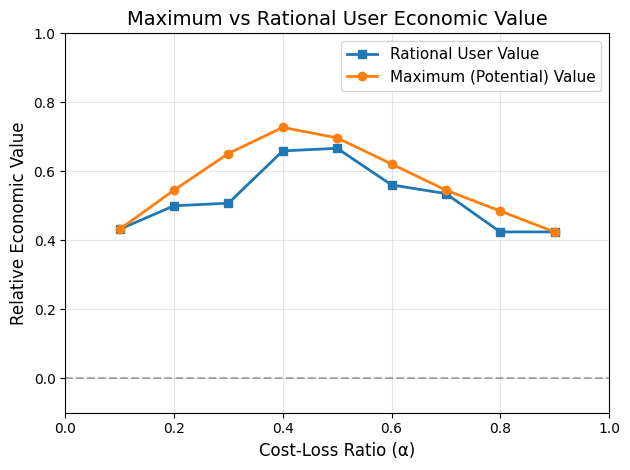

In [8]:
matching_values = np.linspace(0, 1, 10, endpoint=False)

# A requirement of "rational_user" is that the cost_loss_ratios and threshold values match
rev_special = relative_economic_value(
    fcst_probabilistic, 
    obs, 
    cost_loss_ratios=matching_values,
    threshold=matching_values,
    special_outputs=['maximum', 'rational_user']
)

print("REV for rational users (using probability directly):")
print(rev_special['rational_user'])
print("\nMaximum REV at each cost-loss ratio:")
print(rev_special['maximum'])

plt.plot(matching_values, rev_special['rational_user'], 
        marker='s', linewidth=2, label='Rational User Value')
plt.plot(matching_values, rev_special['maximum'], 
        marker='o', linewidth=2, label='Maximum (Potential) Value')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Cost-Loss Ratio (α)', fontsize=12)
plt.ylabel('Relative Economic Value', fontsize=12)
plt.title('Maximum vs Rational User Economic Value', fontsize=14)
plt.ylim(-0.1, 1) 
plt.xlim(0, 1) 

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Working with Ensemble Forecasts

Ensemble forecasts represent uncertainty through multiple members. We can convert ensembles to probabilities using `binary_discretise_proportion`, then evaluate their economic value.

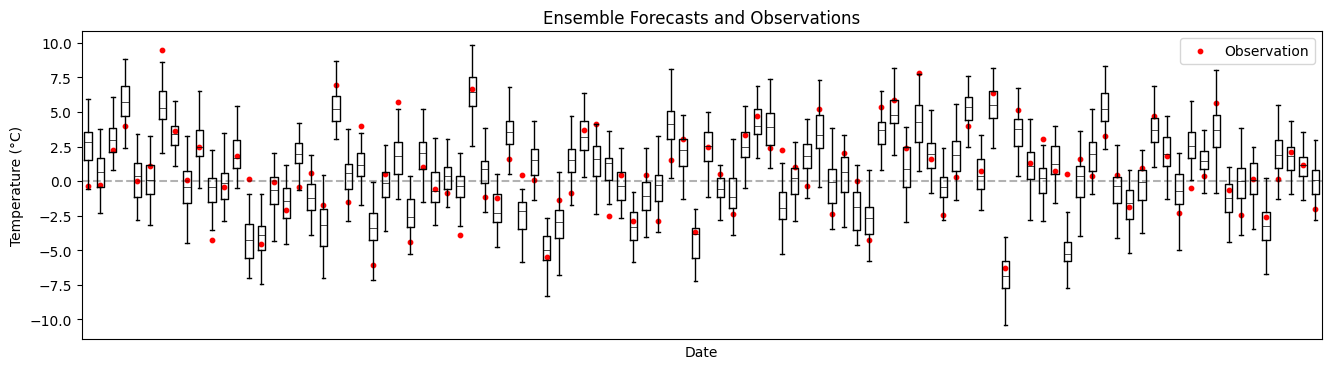

In [9]:
# Create a synthetic 50-member ensemble forecast for temperature
# Event of interest: temperature below 0°C (freezing)
n_times = 100
n_members = 50
np.random.seed(42)
# Generate ensemble with some skill
seed_temps = np.random.normal(1, 3, n_times) 
obs_temps = seed_temps + np.random.normal(0, 2, n_times)

ensemble = np.random.normal(
    seed_temps[:, np.newaxis],
    1.5,  # Ensemble spread
    (n_times, n_members)
)

ensemble_xr = xr.DataArray(
    ensemble,
    dims=["time", "member"],
    coords={
        "time": np.arange(n_times),
        "member": np.arange(n_members)
    }
)

# Observations
obs_xr = xr.DataArray(
    obs_temps,
    dims=["time"],
    coords={"time": np.arange(n_times)}
)

times = ensemble_xr["time"].values
ensemble_values = ensemble_xr.values

fig, ax = plt.subplots(figsize=(16, 4))

ax.boxplot(
    ensemble_values.T,
    positions=times,
    widths=0.6,
    showfliers=False,
    medianprops=dict(color='black', linewidth=0.5),  # invisible
)

ax.scatter(times, obs_xr.values, color="red", s=10, label="Observation")

ax.set_xlabel("Date")
ax.set_xticks([])
ax.set_ylabel("Temperature (°C)")
ax.set_title("Ensemble Forecasts and Observations")
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.legend()
plt.show()

Forecast chance of frost
<xarray.DataArray (time: 100)> Size: 800B
array([0.04, 0.38, 0.  , 0.  , 0.4 , 0.48, 0.  , 0.02, 0.6 , 0.04, 0.68,
       0.54, 0.04, 1.  , 1.  , 0.68, 0.82, 0.08, 0.82, 0.94, 0.  , 0.32,
       0.18, 1.  , 0.52, 0.12, 0.92, 0.1 , 0.68, 0.44, 0.64, 0.  , 0.3 ,
       0.94, 0.02, 0.98, 0.14, 1.  , 0.98, 0.16, 0.  , 0.2 , 0.22, 0.56,
       1.  , 0.76, 0.54, 0.  , 0.06, 1.  , 0.06, 0.7 , 0.72, 0.12, 0.02,
       0.  , 0.84, 0.48, 0.08, 0.02, 0.54, 0.34, 0.86, 0.9 , 0.02, 0.  ,
       0.34, 0.  , 0.04, 0.7 , 0.16, 0.  , 0.38, 0.  , 1.  , 0.  , 0.22,
       0.48, 0.16, 1.  , 0.44, 0.1 , 0.  , 0.7 , 0.9 , 0.52, 0.  , 0.02,
       0.64, 0.  , 0.16, 0.02, 0.84, 0.5 , 0.48, 0.96, 0.12, 0.1 , 0.16,
       0.48])
Coordinates:
  * time     (time) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Attributes:
    discretisation_tolerance:  0
    discretisation_mode:       <
Observed frost instances
<xarray.DataArray (time: 100)> Size: 800B
array([1, 1, 0, 0, 1, 0,

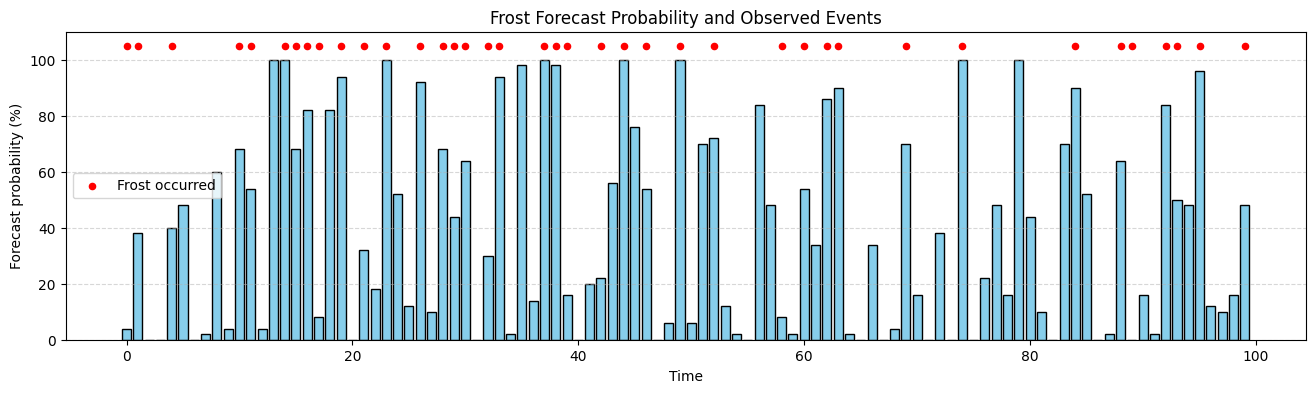

In [10]:
# Convert ensemble to probability of freezing using binary_discretise_proportion
prob_freezing = binary_discretise_proportion(
    ensemble_xr,
    thresholds=[0],  # Event threshold: temperature < 0°C
    mode='<',
    reduce_dims=['member']  # Calculate proportion across ensemble members
)

# Rename dimension to avoid conflict with REV's threshold parameter
prob_freezing = prob_freezing.rename({'threshold': 'event_threshold'})

# Extract probability for 0°C threshold
prob_freezing_0c = prob_freezing.sel(event_threshold=0, drop=True)
print("Forecast chance of frost")
print(prob_freezing_0c)

# Convert observations to binary: did it freeze (1) or not (0)?
obs_freezing_0c = (obs_xr < 0).astype(int)

print("Observed frost instances")
print(obs_freezing_0c)

fig, ax = plt.subplots(figsize=(16, 4))

ax.bar(times, prob_freezing_0c.values* 100, color="skyblue", edgecolor="black")

# Overlay observations as dots at the top of the chart
y_top = 105  # a bit above 100%
ax.scatter(times[obs_freezing_0c.values == 1], np.full(obs_freezing_0c.values.sum(), y_top),
           color="red", s=20, label="Frost occurred")

# Labels and styling
ax.set_xlabel("Time")
ax.set_ylabel("Forecast probability (%)")
ax.set_ylim(0, 110)
ax.set_title("Frost Forecast Probability and Observed Events")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)


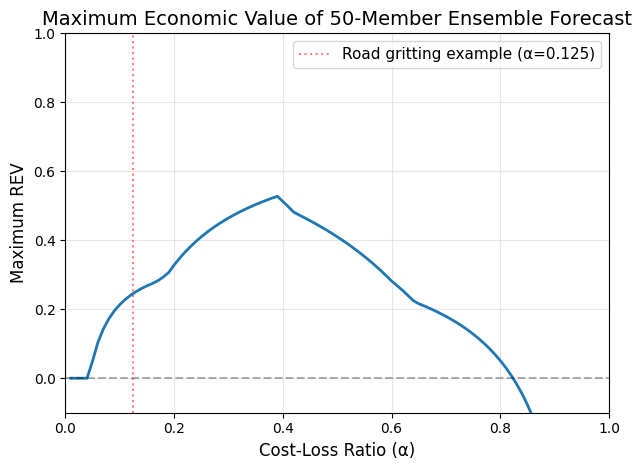

In [11]:
# Now calculate REV using these ensemble-derived probabilities
matching_values = np.linspace(0, 1, 100, endpoint=False)

rev_ensemble = relative_economic_value(
    prob_freezing_0c,
    obs_freezing_0c,
    cost_loss_ratios=matching_values,
    threshold=matching_values,
    special_outputs=['maximum']
)

# Plot
plt.plot(matching_values , rev_ensemble['maximum'], linewidth=2)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0.125, color='red', linestyle=':', alpha=0.5, 
           label='Road gritting example (α=0.125)')
plt.xlabel('Cost-Loss Ratio (α)', fontsize=12)
plt.ylabel('Maximum REV', fontsize=12)
plt.title('Maximum Economic Value of 50-Member Ensemble Forecast', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(-0.1, 1)
plt.tight_layout()
plt.show()

## Working with Multiple Dimensions

REV can preserve spatial or other dimensions while aggregating over time.

In [12]:
# Create forecast with spatial dimension (e.g., different road segments)
n_locations = 5
n_days = 100

fcst_spatial = xr.DataArray(
    np.random.uniform(0, 1, (n_days, n_locations)),
    dims=['time', 'location'],
    coords={
        'time': np.arange(n_days),
        'location': ['Route_A', 'Route_B', 'Route_C', 'Route_D', 'Route_E']
    }
)

# Different base rates for different locations
base_rates = np.array([0.1, 0.15, 0.25, 0.3, 0.6])
obs_spatial = xr.DataArray(
    np.random.binomial(1, base_rates + 0.3 * fcst_spatial.values, (n_days, n_locations)),
    dims=['time', 'location'],
    coords={'time': np.arange(n_days), 'location': fcst_spatial.location}
)

# Calculate REV, preserving location dimension
rev_spatial = relative_economic_value(
    fcst_spatial,
    obs_spatial,
    cost_loss_ratios=[0.1],
    threshold=[0.1, 0.2, 0.3],
    reduce_dims=['time'],  # Aggregate over time, preserve location
)

print("REV at each location:")
print(rev_spatial.to_dataframe("REV").unstack("threshold"))

# Reducing the time dimension is the same as preserving the location dimension.
# You cannot specify preserve_dims and reduce_dims at the same time. 
rev_preserve_dim = relative_economic_value(
    fcst_spatial,
    obs_spatial,
    cost_loss_ratios=[0.1],
    threshold=[0.1, 0.2, 0.3],
    preserve_dims=['location'],
)

if rev_preserve_dim.equals(rev_spatial):
    print("\nPreserving dimensions and reducing dimensions are two ways of achieving the same result.")


REV at each location:
                               REV                    
threshold                      0.1       0.2       0.3
location cost_loss_ratio                              
Route_A  0.1             -0.012048  0.024096  0.180723
Route_B  0.1             -0.394737 -0.342105 -0.289474
Route_C  0.1             -0.491525 -0.966102 -1.372881
Route_D  0.1             -0.177419 -0.064516 -0.516129
Route_E  0.1             -1.750000 -4.821429 -5.642857

Preserving dimensions and reducing dimensions are two ways of achieving the same result.


## Custom Dimension Names and Extracting Particular Thresholds

You can customize the output dimension names to avoid conflicts. You can also output a subset of your selected thresholds. 

In [13]:
rev_custom = relative_economic_value(
    fcst_spatial,
    obs_spatial,
    cost_loss_ratios=[0.1, 0.3, 0.5],
    threshold=[0.1, 0.2, 0.4, 0.6],
    threshold_dim='decision_threshold',
    cost_loss_dim='alpha'
)

print("REV with custom dimension names:")
print(rev_custom)

rev_subset = relative_economic_value(
    fcst_spatial,
    obs_spatial,
    cost_loss_ratios=[0.1, 0.3, 0.5],
    threshold=[0.1, 0.2, 0.4, 0.6],
    threshold_outputs=[0.1, 0.6], 
)

print("\n\nREV with a subset of output thresholds:")
print(rev_subset)

REV with custom dimension names:
<xarray.DataArray (decision_threshold: 4, alpha: 3)> Size: 96B
array([[-0.38961039, -0.02164502, -0.52083333],
       [-0.71428571, -0.02164502, -0.41666667],
       [-1.37337662, -0.00974026, -0.18229167],
       [-2.3538961 , -0.10281385, -0.046875  ]])
Coordinates:
  * decision_threshold  (decision_threshold) float64 32B 0.1 0.2 0.4 0.6
  * alpha               (alpha) float64 24B 0.1 0.3 0.5


REV with a subset of output thresholds:
<xarray.Dataset> Size: 72B
Dimensions:          (cost_loss_ratio: 3)
Coordinates:
  * cost_loss_ratio  (cost_loss_ratio) float64 24B 0.1 0.3 0.5
Data variables:
    threshold_0_1    (cost_loss_ratio) float64 24B -0.3896 -0.02165 -0.5208
    threshold_0_6    (cost_loss_ratio) float64 24B -2.354 -0.1028 -0.04688


## Working with Dask

For large datasets, you will want lazy evaluation—computing only when necessary rather than loading everything into memory. Dask provides this through chunked arrays.

By default, the REV function validates inputs (checking dimensions match, data types are correct, etc.). With Dask arrays, these checks force premature computation, defeating the purpose of lazy evaluation. Setting check_args=False bypasses validation and preserves the lazy computation graph.

Dask scales efficiently to datasets too large for memory. The function processes chunks independently, and Dask handles the orchestration behind the scenes.


In [14]:
import dask.array as da

fcst_np = np.array([1, 1, 0, 0, 1]) # perfect forecasts 
obs_np = np.array([1, 1, 0, 0, 1])

fcst = xr.DataArray(da.from_array(fcst_np, chunks=2), dims=["time"])
obs = xr.DataArray(da.from_array(obs_np, chunks=2), dims=["time"])

result = relative_economic_value(fcst, obs, [0.5], check_args=False)

# Computation has not yet happened, so we can verify that the result is still lazy
assert isinstance(result.data, da.Array)

# Calling compute triggers actual calculation
computed = result.compute()

# Which allows us to compare it to the expected result
expected = xr.DataArray([1.0], dims=["cost_loss_ratio"], coords={"cost_loss_ratio": [0.5]})
xr.testing.assert_allclose(computed, expected)

## References

- Murphy, A. H. (1977). The value of climatological, categorical and probabilistic forecasts in the cost-loss ratio situation. Monthly Weather Review, 105(7), 803-816.
- Richardson, D. S. (2000). Skill and relative economic value of the ECMWF ensemble prediction system. Quarterly Journal of the Royal Meteorological Society, 126(563), 649-667.
- Roulin, E. (2007). Skill and relative economic value of medium-range hydrological ensemble predictions. Hydrology and Earth System Sciences, 11(2), 725-737.
- Thornes, J. E., & Stephenson, D. B. (2001). How to judge the quality and value of weather forecast products. Meteorological Applications, 8(3), 307-314.
- Thornes, J. E. (2002, January). The Quality and Value of Road Weather Forecast. In The Proceedings of The 11th. PIARC International Winter Road Congress. (https://proceedings-sapporo2002.piarc.org/en/pdf/doc_pdf/communications/V58e.pdf)
- Zhu, Y., Toth, Z., Wobus, R., Richardson, D., & Mylne, K. (2002). The economic value of ensemble-based weather forecasts. Bulletin of the American Meteorological Society, 83(1), 73-84.